### This notebook follows the example given on the TRAK website:

### Here is the tutorial: https://trak.readthedocs.io/en/latest/bert.html

### Here is the code: https://github.com/MadryLab/trak/blob/main/examples/qnli.py

Here is the link to finetune BERT for qnli: https://github.com/huggingface/transformers/tree/main/examples/pytorch/text-classification

## 1. Import Packages

In [ ]:
!pip install datasets
#!pip install transformers
#!pip install traker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00


In [ ]:
pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
from argparse import ArgumentParser
from tqdm import tqdm

import torch as ch
import torch.nn as nn
from torch.utils.data import DataLoader

from trak import TRAKer

from tqdm.auto import tqdm
import numpy as np
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss, Conv2d, BatchNorm2d
from torch.optim import SGD, lr_scheduler

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: ignored

In [ ]:
# Huggingface
from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    default_data_collator,
)

## 2. Define Sequence Classification Model

In [ ]:
# class SequenceClassificationModel(nn.Module):
#     """
#     Wrapper for HuggingFace sequence classification models.
#     """
#     def __init__(self):
#         super().__init__()

#         self.config = AutoConfig.from_pretrained(
#             'bert-base-cased',
#             num_labels=2,
#             finetuning_task='qnli',
#             cache_dir=None,
#             revision='main',
#             use_auth_token=None,
#         )

#         self.model = AutoModelForSequenceClassification.from_pretrained(
#             'bert-base-cased',
#             config=self.config,
#             cache_dir=None,
#             revision='main',
#             use_auth_token=None,
#             ignore_mismatched_sizes=False
#         ) # jyh: init a bert-based classification model w/ pretrained weights.
#         self.model.eval().cuda()

#     def forward(self, input_ids, token_type_ids, attention_mask):
#         return self.model(input_ids=input_ids,
#                           token_type_ids=token_type_ids,
#                           attention_mask=attention_mask).logits


# def get_dataset(split, inds=None):
#     raw_datasets = load_dataset( # jyh: load qnli dataset.
#             "glue",
#             'qnli',
#             cache_dir=None,
#             use_auth_token=None,
#         )
#     label_list = raw_datasets["train"].features["label"].names
#     sentence1_key, sentence2_key = GLUE_TASK_TO_KEYS['qnli']

#     label_to_id = None  # {v: i for i, v in enumerate(label_list)}

#     tokenizer = AutoTokenizer.from_pretrained(
#         'bert-base-cased',
#         cache_dir=None,
#         use_fast=True,
#         revision='main',
#         use_auth_token=False
#     )

#     padding = "max_length"
#     max_seq_length = 128

#     def preprocess_function(examples):
#         # Tokenize the texts
#         args = (
#             (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
#         )
#         result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

#         # Map labels to IDs (not necessary for GLUE tasks)
#         if label_to_id is not None and "label" in examples:
#             result["label"] = [(label_to_id[lbl] if lbl != -1 else -1) for lbl in examples["label"]]
#         return result

#     raw_datasets = raw_datasets.map(
#         preprocess_function,
#         batched=True,
#         load_from_cache_file=(not False),
#         desc="Running tokenizer on dataset",
#     )

#     if split == 'train':
#         train_dataset = raw_datasets["train"]
#         ds = train_dataset
#     else:
#         eval_dataset = raw_datasets["validation"]
#         ds = eval_dataset
#     return ds


# def init_model(ckpt_path, device='cuda'):
#     model = SequenceClassificationModel()
#     sd = ch.load(ckpt_path)
#     model.model.load_state_dict(sd)
#     return model


# def init_loaders(batch_size=16):
#     ds_train = get_dataset('train')
#     ds_train = ds_train.select(range(TRAIN_SET_SIZE))
#     ds_val = get_dataset('val')
#     ds_val = ds_val.select(range(VAL_SET_SIZE))
#     return DataLoader(ds_train, batch_size=batch_size, shuffle=False, collate_fn=default_data_collator), \
#         DataLoader(ds_val, batch_size=batch_size, shuffle=False, collate_fn=default_data_collator)

In [ ]:
def process_batch(batch):
    # return batch['input_ids'], batch['token_type_ids'], batch['attention_mask'], batch['labels']
    return batch[0], batch[1], batch[1], batch[2]

**Use the above: We will use a pre-trained language model (bert-base-cased) from HuggingFace and finetune it on the QNLI (Question-answering NLI) task, which is a binary classification task.**

bert-base-cased fine tuned on qnli: https://huggingface.co/gchhablani/bert-base-cased-finetuned-qnli/tree/main


## Set up the e-commerce dataset

In [ ]:
import pandas as pd
import csv
from datasets import Dataset
#load csv downloaded from kaggle
# Load your CSV file into a Pandas DataFrame
#csv_path = '/content/gdrive/My Drive/ecommerceDataset.csv' # jyh: your path here!
#df = pd.read_csv(csv_path, names=['class','text'])#

In [ ]:
#df = df.dropna()

In [ ]:
#dataset = Dataset.from_pandas(df)

# Print the first few examples to verify the dataset
#print(dataset)
## Save the dataset if needed
#hf_dataset.save_to_disk('your_dataset_name')
#dataset['text'][0]

In [ ]:
#df=df.sample(frac=1)

In [ ]:
#dataset = dataset.train_test_split(test_size=0.3)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
from datasets import Dataset
import csv
import itertools as it
import numpy as np
import sklearn.decomposition
np.random.seed(0)
from tqdm import tqdm

# Load your CSV file into a Pandas DataFrame
# csv_path = '/content/drive/MyDrive/ecommerceDataset.csv'
csv_path = "/content/gdrive/MyDrive/Colab Notebooks/mit-nlp-project/ecommerceDataset.csv" # jyh: your path here!
df = pd.read_csv(csv_path,names=['class','text'])#
df=df.sample(frac=1)
df['class_int'] = pd.factorize(df['class'])[0].astype(int)
df=df.dropna()
#print(df['class'].unique())
# print(len(df[df['class'] == 'Books']))
print(len(df))
df

# df_holdout = df[df['class_int'] == 2]
#df = df.drop(df[df['class_int'] == 2].index)
#remap class int label so model
#df.loc[df.class_int >= 2,'class_int'] =df.loc[df.class_int >= 2,'class_int'] -1
#df.class_int.unique()

# n_lab = len(df['class'].unique())
# print(n_lab)

# assert n_lab == 3

50424


,class,text,class_int
16792,Household,Address America Yard Sign [Custom House Addres...,0
4034,Household,Gifts Collection Switch Board Sticker Wall Sti...,0
44280,Electronics,Olympus M 2 GB xD-Picture Card Flash Memory Ca...,1
37846,Clothing & Accessories,AV2 Women's Cotton Nursing / Feeding / Materni...,2
15576,Household,FAVY Laurels 2 ROD HALOGEN HEATER || ISI Appro...,0
...,...,...,...
21243,Books,The Man From The Egg: Unusual Tales About The ...,3
45891,Electronics,Digitek LP-E8 Camera Battery Replaces Canon LP...,1
42613,Electronics,"HP 245 G5,P1b38PA / 14 Inch / AMD A6 Quadcore ...",1
43567,Electronics,"Lenovo All In One Desktop C2000(F0BB00YDIN,CPU...",1


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


from matplotlib import pyplot as plt
df['class_int'].plot(kind='hist', bins=20, title='class_int')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['class_int'].plot(kind='line', figsize=(8, 4), title='class_int')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='class_int', y='class', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

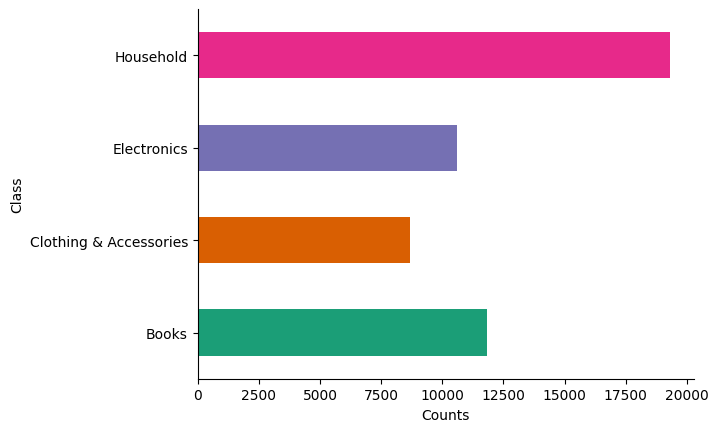

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("Counts")
plt.ylabel("Class")

plt.savefig("class_histogram.png", bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt

(array([19313.,     0.,     0., 10621.,     0.,     0.,  8670.,     0.,
            0., 11820.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

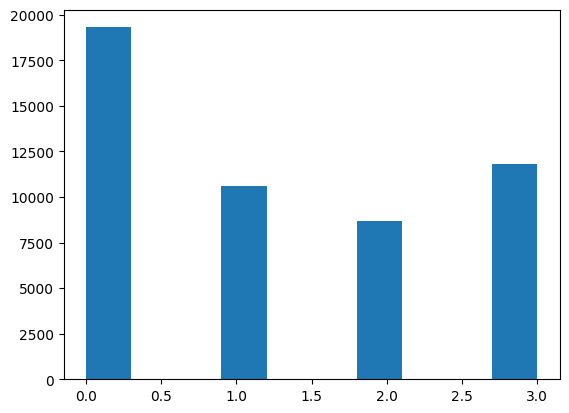

In [ ]:
plt.hist(df['class_int'])

In [ ]:
#small datset for smoke test
#train_reviews, train_labels = list(df.text[:3000]), list(df['class_int'][:3000])
#val_reviews, val_labels = list(df.text[3000:4000]), list(df['class_int'][3000:4000])

l = len(df)
train_end = int(l*0.7)
val_end = int(l*0.85)
train_reviews, train_labels = list(df.text[:train_end]), list(df['class_int'][:train_end])
val_reviews, val_labels = list(df.text[train_end:val_end]), list(df['class_int'][train_end:val_end])


In [ ]:
ho_reviews, ho_labels = list(df_holdout.text), list(df_holdout['class_int'])

In [ ]:
ls /content/gdrive/MyDrive/mit-nlp-project

/content/gdrive/MyDrive/mit-nlp-project@


In [ ]:
#model_name = f'/content/drive/MyDrive/model_lr{lr}_bs{bs}_undersamp{k}.pt'
import pickle
from google.colab import drive
drive.mount('/content/gdrive')
file_name = f'/content/gdrive/MyDrive/mit-nlp-project/final_datasets_0_.01_.1_1.pickle'
#file_name = f'/content/gdrive/MyDrive/mit-nlp-project/datasets_mislabeled.pickle'
with open(file_name, 'rb') as handle:
    ds = pickle.load(handle)
ds

#val_dataset, train_dataset = ds['val'], ds['train']
ds

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


{0.0:                         class  \
 1651                Household   
 7859                Household   
 8654                Household   
 44130             Electronics   
 43979             Electronics   
 ...                       ...   
 46086             Electronics   
 37970  Clothing & Accessories   
 2998                Household   
 14100               Household   
 16208               Household   
 
                                                     text  class_int  
 1651   Joyo Multi-Utility Compact Foldable Table,(Mus...          1  
 7859   Le Craf Men's Brown Genuine Leather RFID Block...          1  
 8654   Philips Ultra Slim Plus 12-Watt Recessed LED P...          1  
 44130  DeckUp Meritus-S Wall TV Unit (Dark Wenge, Mat...          0  
 43979  AmazonBasics 3.5mm to 2-Male RCA Adapter cable...          0  
 ...                                                  ...        ...  
 46086  SPE 52mm To 58mm 52-58MM Lens Step Up Filter R...          0  
 37970  GOLDSTROM

In [ ]:
ds.keys()

dict_keys([0.0, 0.01, 0.1, 1, 'eval'])

## Setting up for DistilBERT model

In [ ]:
import torch
from torch.utils.data import TensorDataset
#match distillbert to include token_type_id
def tokenizer_function(input_data, labels):
  input_ids = []
  attention_masks = []
  for sent in input_data:
    this_encoding = tokenizer.encode_plus(sent, truncation=True, pad_to_max_length = True,max_length = 512,return_attention_mask = True,return_tensors = 'pt')
    input_ids.append(this_encoding['input_ids'])
    attention_masks.append( this_encoding['attention_mask'])
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  tokenized_data = TensorDataset(input_ids, attention_masks, labels)
  return tokenized_data

In [ ]:
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch.nn.functional as F
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# from transformers import AutoTokenizer
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
train_dataset = tokenizer_function(train_reviews, train_labels)
val_dataset = tokenizer_function(val_reviews, val_labels)


In [ ]:
ho_dataset = tokenizer_function(ho_reviews, ho_labels)

In [ ]:
datasets0 = [train_dataset,val_dataset,ho_dataset]
import pickle
from google.colab import drive
drive.mount('/content/gdrive')
file_name = f'/content/gdrive/MyDrive/mit-nlp-project/0_ds_train_val_ho.pickle'
with open(file_name, 'wb') as handle:
    pickle.dump(datasets0, handle, protocol=pickle.HIGHEST_PROTOCOL)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_dataset,val_dataset = ds[0.01]

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Checkpoint Path.
CKPT_PATH = "/content/gdrive/MyDrive/mit-nlp-project/model_lr5e-05_bs32.pt" # "/content/gdrive/MyDrive/mit-nlp-project/model_lr5e-05_bs32_undersamp0.01.pt"#jyh: to load model checkpoints from huggingface: https://huggingface.co/gchhablani/bert-base-cased-finetuned-qnli/tree/main/checkpoint-13094
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=n_lab, output_attentions = False, output_hidden_states=False)
# sd = ch.load(CKPT_PATH)
# model.load_state_dict(sd)
# model = SequenceClassificationModel()
# sd = ch.load(CKPT_PATH)
# model.model.load_state_dict(sd)
CKPT_PATH =  "/content/gdrive/MyDrive/mit-nlp-project/mislabeled_data/final_model_lr5e-05_bs32_undersamp{k}.pt"

## Write a Model Wrapper to Fit TRAK API Signatures

In [ ]:
from transformers import (
    # AutoConfig, # jyh (11/17): do we need to tweak this for DistilBert?
    DistilBertConfig, # jyh (11/17): https://huggingface.co/docs/transformers/v4.35.2/en/model_doc/distilbert#transformers.DistilBertConfig
    # AutoModelForSequenceClassification,
    DistilBertForSequenceClassification
)

class DistilBertSequenceClassificationModel(nn.Module):
    """
    Wrapper for HuggingFace sequence classification models.
    """
    def __init__(self):
        super().__init__()
        n_lab = 4#len(set(train_labels))

        # self.config = AutoConfig.from_pretrained(
        #     'distilbert-base-cased',
        #     num_labels=n_lab,
        #     finetuning_task='qnli',
        #     cache_dir=None,
        #     revision='main',
        #     use_auth_token=None,
        # )

        self.config = DistilBertConfig.from_pretrained(
            'distilbert-base-cased',
            num_labels=n_lab
            # finetuning_task='qnli',
            # cache_dir=None,
            # revision='main',
            # use_auth_token=None,
        )


        # self.model = AutoModelForSequenceClassification.from_pretrained(
        #     'bert-base-cased',
        #     config=self.config,
        #     cache_dir=None,
        #     revision='main',
        #     use_auth_token=None,
        #     ignore_mismatched_sizes=False
        # )
        # self.model.eval().cuda()

        self.model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-cased',
            num_labels=n_lab,
            output_attentions = False,
            output_hidden_states=False
        )
        self.model.eval().to(device)

    def forward(self, input_ids, token_type_ids, attention_mask): # jyh (11/17): TRAK calls for a slight tweak in the forward function to fit API signatures: https://trak.readthedocs.io/en/latest/bert.html
        return self.model(input_ids=input_ids,
            # token_type_ids=token_type_ids,
            attention_mask=attention_mask).logits



In [ ]:
import transformers
print(transformers.__version__)

from torch.utils.data import DataLoader

4.35.2


In [ ]:
def init_model(ckpt_path, device):
    # model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=n_lab, output_attentions = False, output_hidden_states=False)
    model = DistilBertSequenceClassificationModel()
    sd = ch.load(ckpt_path, map_location=torch.device('cuda')) # jyh: (11/18) this worked for the baseline DistilBertSequenceClassificationModel.
    # checkpoint = torch.load(CKPT_PATH, map_location=torch.device('cpu'))
    # print(checkpoint.keys())
    # print("type chkpt", type(checkpoint))
    # print("type chkpt keys", type(checkpoint.keys()))
    model.model.load_state_dict(sd)
    return model

## 3. Run TRAK on Model

In [ ]:
CKPT_PATH

'/content/gdrive/MyDrive/mit-nlp-project/mislabeled_data/final_model_lr5e-05_bs32_undersamp{k}.pt'

In [ ]:
from argparse import Namespace
CKPT_PATH = CKPT_PATH#"/content/gdrive/My Drive//model_lr5e-05_bs32.pt"

# Simulating command line arguments in Google Colab
args = Namespace(
    ckpt=CKPT_PATH, # jyh: we must fine-tune bert-base-cased on nqli data!
    out='/content/gdrive/MyDrive/mit-nlp-project/mislabeled_data'
)


In [ ]:
len(train_dataset)

40339

In [ ]:
import gc
torch.cuda.empty_cache()


In [ ]:
#ho_val = DataLoader(ho_dataset, batch_size=8, shuffle=True)


In [ ]:

#if __name__ == "__main__":
# parser = ArgumentParser()
# parser.add_argument('--ckpt', type=str, help='model checkpoint', required=True)
# parser.add_argument('--out', type=str, help='dir to save TRAK scores and metadata to', required=True)
# args = parser.parse_args()
%pdb
# device = 'cuda'
device = 'cuda'
import gc
torch.cuda.empty_cache()

# loader_train, loader_val = init_loaders()
print(type(train_dataset))
TRAIN_SET_SIZE = len(train_reviews)
VAL_SET_SIZE = len(val_reviews)
HO_SET_SIZE = len(ho_reviews)

print(f'train set size: {TRAIN_SET_SIZE}')
print(f'val set size: {VAL_SET_SIZE}')
loader_train = DataLoader(train_dataset, batch_size=8, shuffle=False) # jyh: (11/18) decrease batch_size for .featurize
loader_val = DataLoader(val_dataset, batch_size=8, shuffle=False)
ho_val = DataLoader(ho_dataset, batch_size=8, shuffle=False)


model = init_model(args.ckpt, device)

traker = TRAKer(model=model,
                task='text_classification',
                train_set_size=TRAIN_SET_SIZE,
                save_dir=args.out,
                device=device,
                proj_dim=512) # 1024 # jyh: (11/18) the error is with RAM.

traker.load_checkpoint(model.state_dict(), model_id=0)

ix=0
for batch in tqdm(loader_train, desc='Featurizing..'):
    ix += 1
    #print(ix)
    # process batch into compatible form for TRAKer TextClassificationModelOutput
    #print(batch)
    batch = process_batch(batch)
    batch = [x.cuda() for x in batch]
    traker.featurize(batch=batch, num_samples=batch[0].shape[0])

traker.finalize_features()



Automatic pdb calling has been turned ON
<class 'torch.utils.data.dataset.TensorDataset'>
train set size: 29227
val set size: 6263


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:STORE:No existing model IDs in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.0.
INFO:STORE:No existing TRAK scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.0.
Finalizing features for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


In [ ]:
traker.start_scoring_checkpoint(exp_name='test_TRAK_val',
                                checkpoint=model.state_dict(),
                                model_id=0,
                                num_targets=VAL_SET_SIZE)
for batch in tqdm(loader_val, desc='Scoring..'):
    batch = process_batch(batch)
    batch = [x.cuda() for x in batch]
    traker.score(batch=batch, num_samples=batch[0].shape[0]) # jyh: (11/18) https://trak.readthedocs.io/en/latest/_modules/trak/traker.html#TRAKer.score


scores_val = traker.finalize_scores(exp_name='test_TRAK_val')

In [ ]:
HO_SET_SIZE = len(ho_reviews)

traker.start_scoring_checkpoint(exp_name='test_TRAK_hoo',
                                checkpoint=model.state_dict(),
                                model_id=0,
                                num_targets=HO_SET_SIZE)
for batch in tqdm(ho_val, desc='Scoring ho ..'):
    batch = process_batch(batch)
    batch = [x.cuda() for x in batch]
    traker.score(batch=batch, num_samples=batch[0].shape[0]) # jyh: (11/18) https://trak.readthedocs.io/en/latest/_modules/trak/traker.html#TRAKer.score
scores_ho = traker.finalize_scores(exp_name='test_TRAK_hoo')



In [ ]:
%pdb
import gc

def make_traker(model_chkpt,train_dataset, save_dir,proj_dim=512,n_lab=4):

  # device = 'cuda'
  device = 'cuda'
  torch.cuda.empty_cache()

  # loader_train, loader_val = init_loaders()
  print(type(train_dataset))
  TRAIN_SET_SIZE = len(train_dataset)
  #VAL_SET_SIZE = len(val_reviews)
  #HO_SET_SIZE = len(ho_reviews)

  print(f'train set size: {TRAIN_SET_SIZE}')
  #print(f'val set size: {VAL_SET_SIZE}')
  loader_train = DataLoader(train_dataset, batch_size=8, shuffle=False) # jyh: (11/18) decrease batch_size for .featurize
  #loader_val = DataLoader(val_dataset, batch_size=8, shuffle=True)
  #ho_val = DataLoader(ho_dataset, batch_size=8, shuffle=True)


  model = init_model(model_chkpt, device)

  traker = TRAKer(model=model,
                  task='text_classification',
                  train_set_size=TRAIN_SET_SIZE,
                  save_dir=save_dir,
                  device=device,
                  proj_dim=proj_dim) # 1024 # jyh: (11/18) the error is with RAM.

  traker.load_checkpoint(model.state_dict(), model_id=0)

  ix=0
  for batch in tqdm(loader_train, desc='Featurizing..'):
      ix += 1
      #print(ix)
      # process batch into compatible form for TRAKer TextClassificationModelOutput
      #print(batch)
      batch = process_batch(batch)
      batch = [x.cuda() for x in batch]
      traker.featurize(batch=batch, num_samples=batch[0].shape[0])

  traker.finalize_features()
  return traker,model



Automatic pdb calling has been turned ON


In [ ]:
type(ds[0.0])

pandas.core.frame.DataFrame

In [ ]:
for samp_p,datasets in ds.items():
  if type(samp_p) is not str  and samp_p > .9 :
    try:
      gc.collect()
      del model
      del traker
    finally:
      pass
    print(samp_p)
    train_dataset = datasets
    val_dataset = ds['eval']

    train_dataset = tokenizer_function(train_dataset.text.tolist(), train_dataset.class_int.tolist())
    val_dataset = tokenizer_function(val_dataset.text.tolist(), val_dataset.class_int.tolist())

    CKPT_PATH = f"/content/gdrive/MyDrive/mit-nlp-project/final_model_lr5e-05_bs32_undersamp{samp_p}.pt"#"/content/model_lr5e-05_bs32.pt" # jyh: to load model checkpoints from huggingface: https://huggingface.co/gchhablani/bert-base-cased-finetuned-qnli/tree/main/checkpoint-13094
    traker,model = make_traker(CKPT_PATH,  train_dataset, f'/content/gdrive/MyDrive/mit-nlp-project/final_{samp_p}/')
    get_trak_scores(traker,model,val_dataset)

1
<class 'torch.utils.data.dataset.TensorDataset'>
train set size: 10085


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
ERROR:TRAK:Could not use CudaProjector.
Reason: No module named 'fast_jl'
ERROR:TRAK:Defaulting to BasicProjector.
INFO:STORE:No existing model IDs in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/final_1.
INFO:STORE:No existing TRAK scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/final_1.


Featurizing..:   0%|          | 0/1261 [00:00<?, ?it/s]

Finalizing features for all model IDs..: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


Scoring..:   0%|          | 0/63 [00:00<?, ?it/s]

Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00, 31.54it/s]
INFO:STORE:Saving scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/final_1/scores/test_TRAK_val.mmap


In [ ]:
from numpy.lib.format import open_memmap

f = '/content/gdrive/MyDrive/mit-nlp-project/final_1/scores/test_TRAK_val.mmap'
_scores_val = open_memmap(f)
_scores_val[1]

memmap([-3.5400e-03,  6.4325e-04,  9.6989e-04, -9.7466e-04,  2.1088e-02,
         7.9727e-04, -9.5367e-07,  1.8873e-03,  2.4242e-03,  4.1866e-04,
         1.0643e-03, -1.9627e-03, -5.7335e-03,  1.0782e-04,  1.0452e-03,
         8.2636e-04, -1.5228e-02, -1.5450e-02,  4.6158e-04,  3.8624e-03,
        -1.3232e-04, -2.3403e-03, -2.0237e-03, -5.1117e-03,  1.0956e-02,
        -2.2888e-02,  2.1172e-03,  1.0004e-03,  1.9150e-03, -1.4410e-03,
        -5.1346e-03,  2.8629e-03,  3.0212e-03,  5.2631e-05, -4.7188e-03,
         4.1902e-05,  7.0143e-04,  3.9601e-04, -1.3137e-04, -2.5883e-03,
        -9.8324e-04, -2.7275e-03, -3.1548e-03, -7.1640e-03,  1.3018e-03,
         4.3416e-04, -4.7350e-04, -6.7425e-04, -7.9956e-03, -3.9787e-03,
         6.4545e-03,  9.3155e-03, -6.9046e-04,  7.2861e-03, -6.5029e-05,
         9.4376e-03, -1.1997e-03,  4.7951e-03, -3.2501e-03,  2.1148e-04,
        -1.9550e-04,  1.7891e-03, -6.6948e-04, -6.4049e-03,  3.1891e-03,
         1.1597e-03, -1.4715e-03, -3.7968e-05,  6.8

In [ ]:
def get_trak_scores(traker,model,val_dataset):
  VAL_SET_SIZE = len(val_dataset)
  loader_val = DataLoader(val_dataset, batch_size=8, shuffle=False)
  traker.start_scoring_checkpoint(exp_name='test_TRAK_val',
                                  checkpoint=model.state_dict(),
                                  model_id=0,
                                  num_targets=VAL_SET_SIZE)
  for batch in tqdm(loader_val, desc='Scoring..'):
      batch = process_batch(batch)
      batch = [x.cuda() for x in batch]
      traker.score(batch=batch, num_samples=batch[0].shape[0]) # jyh: (11/18) https://trak.readthedocs.io/en/latest/_modules/trak/traker.html#TRAKer.score


  scores_val = traker.finalize_scores(exp_name='test_TRAK_val')

In [ ]:
traker,model = make_traker(CKPT_PATH,  train_dataset,'/content/gdrive/MyDrive/mit-nlp-project/mislabeled_data')
get_trak_scores(traker,model,val_dataset)

<class 'torch.utils.data.dataset.TensorDataset'>
train set size: 40339


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:STORE:Existing model IDs in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/mislabeled_data: [0]
INFO:STORE:Model IDs that have been finalized: [0]
INFO:STORE:Existing TRAK scores:
INFO:STORE:test_TRAK_val: /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/mislabeled_data/scores/test_TRAK_val.mmap


Featurizing..:   0%|          | 0/5043 [00:00<?, ?it/s]

Finalizing features for all model IDs..: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Scoring..:   0%|          | 0/1261 [00:00<?, ?it/s]

Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]
INFO:STORE:Saving scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/mislabeled_data/scores/test_TRAK_val.mmap


In [ ]:
1

1

In [ ]:
for samp_p,datasets in ds.items():
  print(samp_p)
  train_dataset, val_dataset = datasets
  CKPT_PATH = f"/content/gdrive/MyDrive/mit-nlp-project/model_lr5e-05_bs32_undersamp{samp_p}.pt"#"/content/model_lr5e-05_bs32.pt" # jyh: to load model checkpoints from huggingface: https://huggingface.co/gchhablani/bert-base-cased-finetuned-qnli/tree/main/checkpoint-13094
  traker,model = make_traker(CKPT_PATH,  train_dataset, f'/content/gdrive/MyDrive/mit-nlp-project/{samp_p}/',str(samp_p))
  get_trak_scores(traker,model,val_dataset)

0.01
<class 'torch.utils.data.dataset.TensorDataset'>
train set size: 29314


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:STORE:Existing model IDs in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.01: [0]
INFO:STORE:Model IDs that have been finalized: [0]
INFO:STORE:Existing TRAK scores:
INFO:STORE:test_TRAK_val: /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.01/scores/test_TRAK_val.mmap


Featurizing..:   0%|          | 0/3665 [00:00<?, ?it/s]

Finalizing features for all model IDs..: 100%|██████████| 1/1 [00:00<00:00, 856.33it/s]


Scoring..:   0%|          | 0/1856 [00:00<?, ?it/s]

Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
INFO:STORE:Saving scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.01/scores/test_TRAK_val.mmap


0.05
<class 'torch.utils.data.dataset.TensorDataset'>
train set size: 29661


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:STORE:No existing model IDs in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.05.
INFO:STORE:No existing TRAK scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.05.


Featurizing..:   0%|          | 0/3708 [00:00<?, ?it/s]

Finalizing features for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


Scoring..:   0%|          | 0/1813 [00:00<?, ?it/s]

Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
INFO:STORE:Saving scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.05/scores/test_TRAK_val.mmap


0.1
<class 'torch.utils.data.dataset.TensorDataset'>
train set size: 30094


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:STORE:No existing model IDs in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.1.
INFO:STORE:No existing TRAK scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.1.


Featurizing..:   0%|          | 0/3762 [00:00<?, ?it/s]

Finalizing features for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


Scoring..:   0%|          | 0/1759 [00:00<?, ?it/s]

Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
INFO:STORE:Saving scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.1/scores/test_TRAK_val.mmap


In [ ]:
get_trak_scores(traker,model,val_dataset)

Scoring..:   0%|          | 0/1856 [00:00<?, ?it/s]

Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
INFO:STORE:Saving scores in /content/.01/scores/test_TRAK_val.mmap


Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
INFO:STORE:Saving scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.0/scores/test_TRAK_val.mmap


Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
INFO:STORE:Saving scores in /content/gdrive/.shortcut-targets-by-id/17LOv6Y-v37cnOBTHPfMiAUwx84qcw99X/mit-nlp-project/0.0/scores/test_TRAK_hoo.mmap


In [ ]:
ls

0/  experiments.json  gdrive/  id_0.json  metadata.json  sample_data/  scores/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import os
os.system('cp /content/* /content/')

256

## VISUALIZING TRAK SCORE


In [ ]:
import mmap

file_path = 'drive/MyDrive/scores/test_TRAK_val.mmap'
output_scores = []
"""train set size: 29227
val set size: 6263"""
with open(file_path, 'r') as file:
    # Open the file in read mode
    with mmap.mmap(file.fileno(), length=0, access=mmap.ACCESS_READ) as mapped_file:
        # Memory map the file
        # Access the contents of the file via mapped_file
        # Perform operations as needed
        #output_scores.append(score)
        print(mapped_file.readline())
        print(mapped_file.readline())



b"\x93NUMPY\x01\x00v\x00{'descr': '<f2', 'fortran_order': False, 'shape': (29227, 6263), }                                                   \n"
b'\x00\x80\x01\x00\xd5\x00\x0e\x80\x00\x80\x1d\x80\x02\x80\x02\x00\x03\x00\x19\x80\x06\x80\x02\x80B\x00,\x00\x02\x00\n'


In [ ]:
# stepping through error outputs in colab.
!ls drive/MyDrive/scores


test_TRAK_2.mmap  test_TRAK_ho.mmap  test_TRAK_hoo.mmap  test_TRAK_val.mmap


In [ ]:
from numpy.lib.format import open_memmap
import numpy as np
# train 29227
# val set size: 6263

_scores_val = open_memmap('drive/MyDrive/scores/test_TRAK_val.mmap')
print(f'scores shape {_scores_val.shape}')
_scores_val[1]
_scores_ho = open_memmap('drive/MyDrive/scores/test_TRAK_hoo.mmap')
print(f'scores shape {_scores_ho.shape}')
_scores_ho[1]

scores shape (29227, 6263)
scores shape (29227, 8670)


memmap([-4.17e-07,  3.64e-06, -3.99e-06, ...,  3.34e-06,  2.98e-06,
         4.17e-06], dtype=float16)

In [ ]:
np.sum((_scores_val[:,1]>0))


16663

In [ ]:
from tqdm import tqdm

def top_n_mean_std(_scores,n=10):
    means = []
    stds = []
    for i in tqdm(range(_scores[1,:].__len__())):
        topn = sorted(_scores[:,i], reverse=True)[:n]
        mean = np.mean(topn)
        std = np.var(topn)
        means.append(mean)
        stds.append(std)
    return means,stds


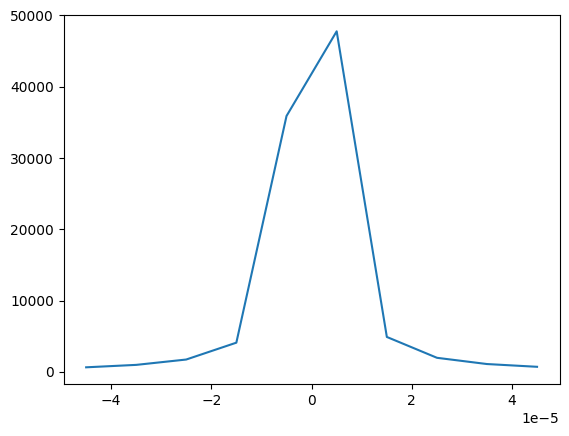

In [ ]:
val_flat = _scores_val.flatten()
import matplotlib.pyplot as plt
(n, bins) = np.histogram(val_flat, bins=10, density=True,range=[-.00005,.00005])  # NumPy version (no plot)
plt.plot(.5 * (bins[1:] + bins[:-1]), n)

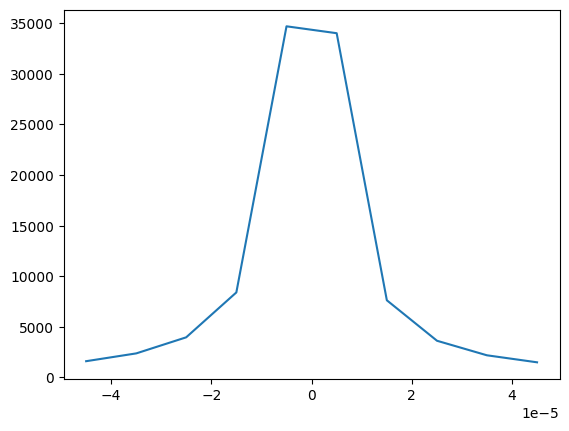

In [ ]:
ho_flat = _scores_ho.flatten()
import matplotlib.pyplot as plt
(n, bins) = np.histogram(ho_flat, bins=10, density=True,range=[-.00005,.00005])  # NumPy version (no plot)
plt.plot(.5 * (bins[1:] + bins[:-1]), n)

In [ ]:
val_flat[:10]

array([-0.00e+00,  5.96e-08,  1.27e-05, -8.34e-07, -0.00e+00, -1.73e-06,
       -1.19e-07,  1.19e-07,  1.79e-07, -1.49e-06], dtype=float16)

In [ ]:

means_val,stds_val = top_n_mean_std(_scores_val)
means_ho,stds_ho = top_n_mean_std(_scores_ho)

 34%|███▍      | 2131/6263 [01:08<02:12, 31.09it/s]


KeyboardInterrupt: ignored

In [ ]:
print(f'val mean: {np.mean(means_val)}')
print(f'val std: {np.mean(stds_val)}')
print(f'ho mean: {np.mean(means_ho)}')
print(f'ho std: {np.mean(stds_ho)}')

val mean: 0.0816650390625
val std: 0.029266357421875
ho mean: 0.25048828125
ho std: 0.051483154296875


In [ ]:
import scipy.stats as stats
stats.ttest_ind(means_val, means_ho, equal_var = False)

TtestResult(statistic=-37.910481155531244, pvalue=2.7052123520123848e-298, df=12918.22765508772)

In [ ]:
import mmap
import torch
import numpy as np
mmap_path='drive/MyDrive/scores/test_TRAK_hoo.mmap'
with open(mmap_path, 'r+b') as file:
    mmapped_file = np.memmap(file,mode='r',dtype=np.float64)
    print(mmapped_file.shape)
    """print(mmapped_file[0])
    print(mmapped_file[1])"""

ValueError: ignored

In [ ]:
!unzip

In [ ]:
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize

# Download the pretrained Word2Vec model (Google News Word2Vec)
# You can find it here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# Make sure to replace the path with the actual path to the downloaded model
word2vec_model_path = 'path/to/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)



# Example: Word vector for a given word
word_vector = word2vec_model['king']
print(f"Vector for 'king': {word_vector}")



# Example: Tokenizing and getting the average vector for a sentence
sentence = "The quick brown fox jumps over the lazy dog"
tokens = word_tokenize(sentence.lower())  # Assuming you have NLTK installed for tokenization
word_vectors = [word2vec_model[token] for token in tokens if token in word2vec_model]
average_vector = sum(word_vectors) / len(word_vectors)
print(f"Average vector for the sentence: {average_vector}")
